In [15]:
from google.cloud import bigquery
from openai import AzureOpenAI
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

os.environ["TOKENIZERS_PARALLELISM"] = "false"

client = bigquery.Client()

project_id_reviews = 'ingka-tugc-infra-prod'
dataset_id_reviews = 'eu_ai_model'
table_id_reviews = 'products_ratings_reviews'

table_ref_reviews = f'{project_id_reviews}.{dataset_id_reviews}.{table_id_reviews}'

project_id_prod_info = 'ingka-explainableai-tpu-dev'
dataset_id_prod_info = 'text_to_sql'
table_id_prod_info = 'item_dim'

table_ref_prod_info = f'{project_id_prod_info}.{dataset_id_prod_info}.{table_id_prod_info}'

# Query to get all the data - 1.17GB to process

query_all = f"""
    SELECT r.art_id, r.title, r.text, concat(r.title, '. ', r.text) as review_text, r.rating, r.country_code, r.lang_code, r.inserted_on, p.pa_name as product_area, type.name as type_name, p.item_name
    FROM `ingka-explainableai-tpu-dev.text_to_sql.item_dim` p 
    INNER JOIN ingka-tugc-infra-prod.eu_ai_model.products_ratings_reviews r
    ON p.item_no = r.art_id
    WHERE p.item_no is not null and lang_code = 'en' and r.country_code = 'us'
"""

query_job = client.query(query_all)
df = query_job.to_dataframe()

print(df.head(5))

     art_id                title  \
0  89260080            Very nice   
1  89260080  Great solid seating   
2  89260080       Almost perfect   
3  89260080             Love it!   
4  19267339      Very Nice Piece   

                                                text  \
0  I was very impressed with this sofa. I wanted ...   
1  I bought the “L” version of this. It is a grea...   
2  I love the look, size and comfort. Just what I...   
3  Love the look it gives my patio. Easy to assem...   
4  My husband put the sofa together rather easily...   

                                         review_text       rating  \
0  Very nice. I was very impressed with this sofa...  5.000000000   
1  Great solid seating. I bought the “L” version ...  5.000000000   
2  Almost perfect. I love the look, size and comf...  5.000000000   
3  Love it!. Love the look it gives my patio. Eas...  5.000000000   
4  Very Nice Piece. My husband put the sofa toget...  5.000000000   

  country_code lang_code       

In [16]:
df["inserted_on"] = pd.to_datetime(df["inserted_on"])
df["rating"] = (df["rating"]).astype(int)
df["review_text"] = df["review_text"].apply(lambda x: str(x).replace('$', ''))

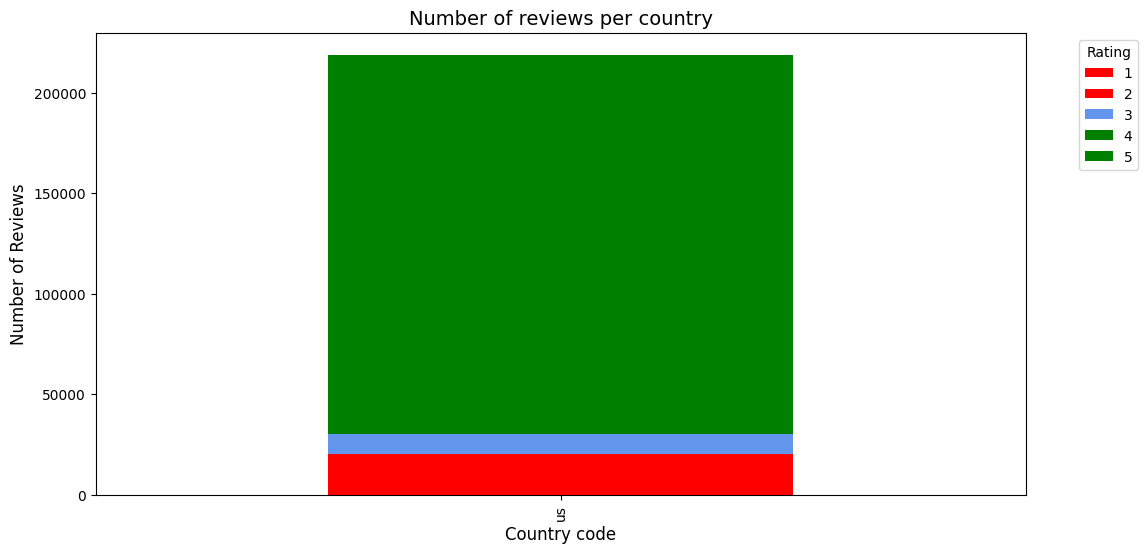

In [17]:
# 1 : Distribution and count

pivot_table = df.pivot_table(index='country_code', columns='rating', aggfunc='size', fill_value=0)

pivot_table = pivot_table.reindex(columns=[1, 2, 3, 4, 5], fill_value=0)

pivot_table['total'] = pivot_table.sum(axis=1)

pivot_table = pivot_table.sort_values(by='total', ascending=False)

pivot_table = pivot_table.drop(columns='total')

pivot_table.plot(kind='bar', stacked=True, figsize=(12, 6),
                 color={1: 'red', 2: 'red', 3: 'cornflowerblue', 4: 'green', 5: 'green'})

plt.title("Number of reviews per country", fontsize=14)
plt.xlabel("Country code", fontsize=12)
plt.ylabel("Number of Reviews", fontsize=12)
plt.xticks(rotation=90)
plt.legend(title='Rating', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


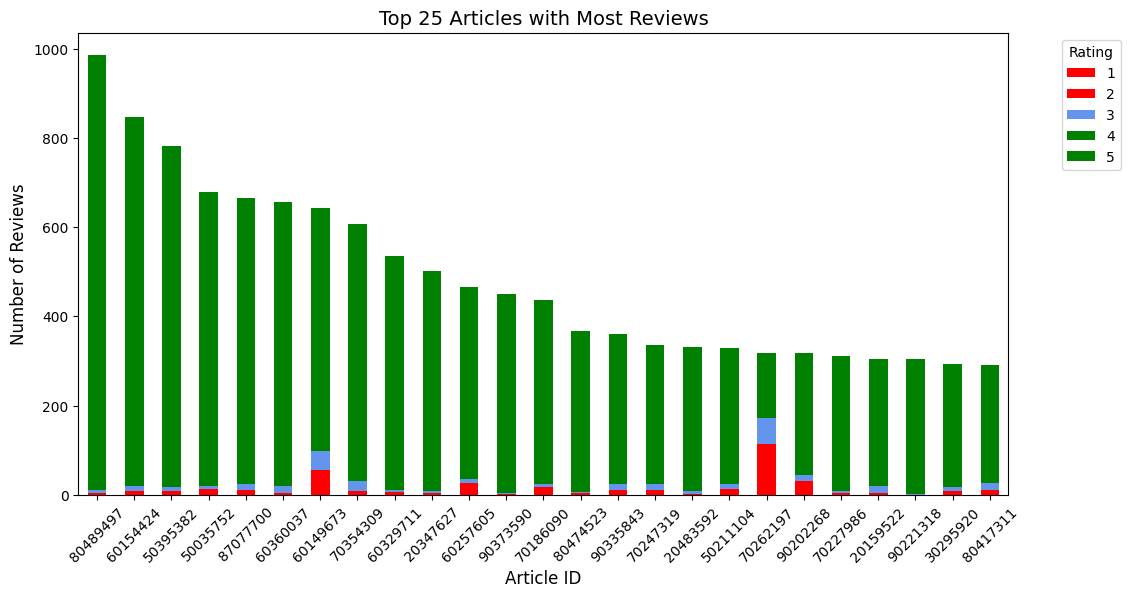


2. Articles Analysis:
Unique Articles: 24289
Top 25 Article Counts:
art_id
80489497    986
60154424    847
50395382    782
50035752    679
87077700    665
60360037    656
60149673    642
70354309    608
60329711    535
20347627    503
60257605    467
90373590    451
70186090    438
80474523    367
90335843    360
70247319    336
20483592    331
50211104    329
70262197    319
90202268    319
70227986    311
20159522    305
90221318    304
30295920    294
80417311    291
Name: count, dtype: int64


In [18]:
# 2 art_id: Identify unique articles and counts with sentiment distribution
article_counts = df['art_id'].value_counts()
unique_articles = df['art_id'].nunique()

top_25_articles = article_counts.nlargest(25).index

df_top_25 = df[df['art_id'].isin(top_25_articles)]

pivot_table = df_top_25.pivot_table(index='art_id', columns='rating', aggfunc='size', fill_value=0)

pivot_table = pivot_table.reindex(columns=[1, 2, 3, 4, 5], fill_value=0)

pivot_table['total'] = pivot_table.sum(axis=1)

pivot_table = pivot_table.sort_values(by='total', ascending=False)

pivot_table = pivot_table.drop(columns='total')

pivot_table.plot(kind='bar', stacked=True, figsize=(12, 6),
                 color={1: 'red', 2: 'red', 3: 'cornflowerblue', 4: 'green', 5: 'green'})

plt.title("Top 25 Articles with Most Reviews", fontsize=14)
plt.xlabel("Article ID", fontsize=12)
plt.ylabel("Number of Reviews", fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Rating', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

print("\n2. Articles Analysis:")
print(f"Unique Articles: {unique_articles}")
print("Top 25 Article Counts:")
print(article_counts.nlargest(25))

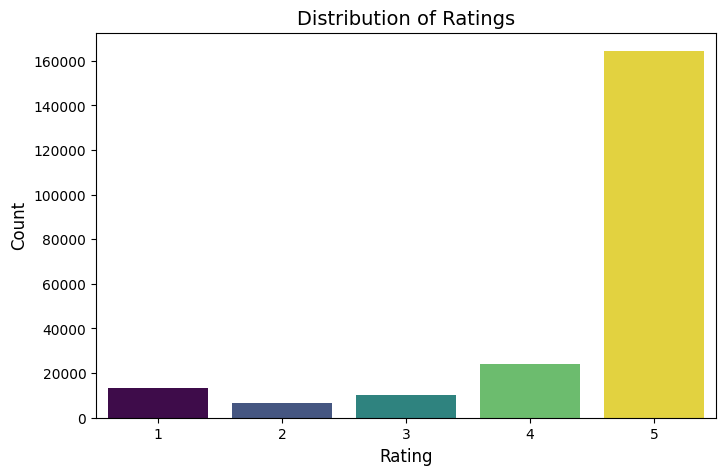

In [19]:
# 3 country_code: Distribution and count

rating_summary = df["rating"].describe()
rating_distribution = df["rating"].value_counts()
plt.figure(figsize=(8, 5))
sns.countplot(x=df["rating"], hue=df["rating"], palette="viridis", legend=False)
plt.title("Distribution of Ratings", fontsize=14)
plt.xlabel("Rating", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.show()

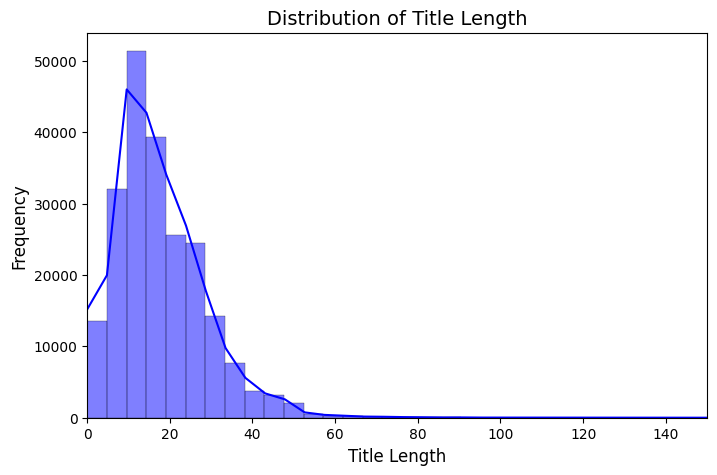


4. Title Length Analysis:
Statistical Summary:
count    218854.000000
mean         18.011784
std          11.737801
min           0.000000
25%          10.000000
50%          16.000000
75%          24.000000
max         952.000000
Name: title_length, dtype: float64
Minimum Title Length: 0
Maximum Title Length: 952


In [20]:
# 4 title: Length analysis and distribution
df["title_length"] = df["title"].apply(len)
title_length_stats = df["title_length"].describe()

plt.figure(figsize=(8,5))
sns.histplot(df["title_length"], bins=200, kde=True, color="blue")
plt.xlim(0, 150)
plt.title("Distribution of Title Length", fontsize=14)
plt.xlabel("Title Length", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.show()

print("\n4. Title Length Analysis:")
print("Statistical Summary:")
print(title_length_stats)
print("Minimum Title Length:", df["title_length"].min())
print("Maximum Title Length:", df["title_length"].max())

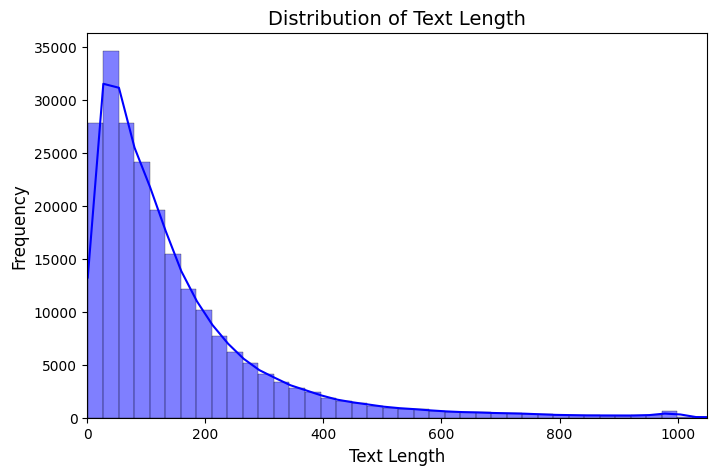


5. Text Length Analysis:
Statistical Summary:
count     218854
unique    207110
top         Good
freq         603
Name: text, dtype: object
Minimum Text Length: 1
Maximum Text Length: 5257


In [21]:
# 5 text: Length analysis (average, shortest, longest text length)
df["text_length"] = df["text"].apply(len)
text_length_stats = df["text"].describe()

plt.figure(figsize=(8,5))
sns.histplot(df["text_length"], bins=200, kde=True, color="blue", legend=False)
plt.xlim(0, 1050)
plt.title("Distribution of Text Length", fontsize=14)
plt.xlabel("Text Length", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.show()

print("\n5. Text Length Analysis:")
print("Statistical Summary:")
print(text_length_stats)
print("Minimum Text Length:", df["text_length"].min())
print("Maximum Text Length:", df["text_length"].max())

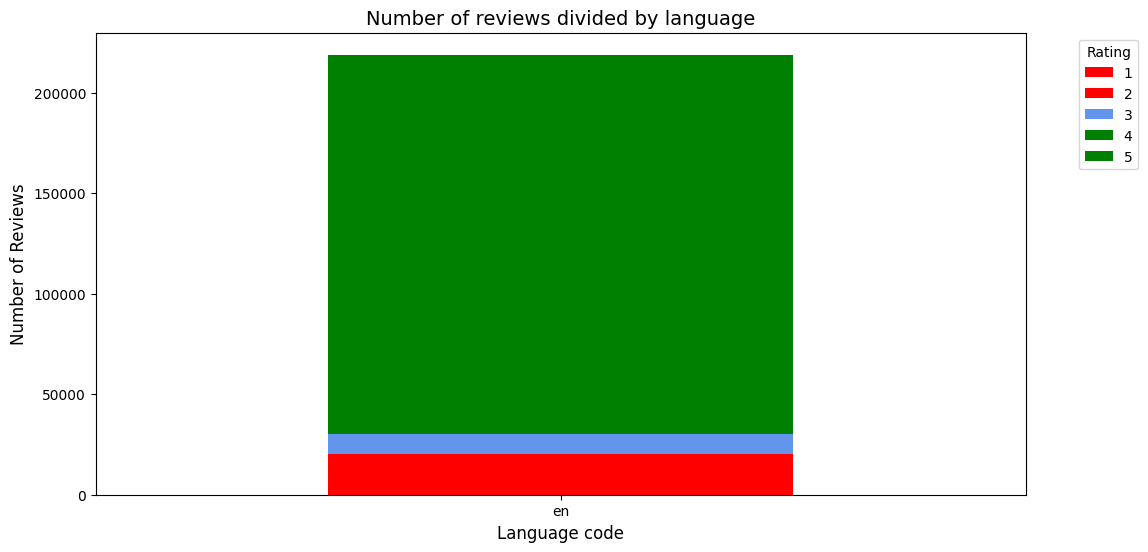

In [22]:
# 6 lang_code: Distribution and count

pivot_table = df.pivot_table(index='lang_code', columns='rating', aggfunc='size', fill_value=0)

pivot_table = pivot_table.reindex(columns=[1, 2, 3, 4, 5], fill_value=0)

pivot_table['total'] = pivot_table.sum(axis=1)

pivot_table = pivot_table.sort_values(by='total', ascending=False)

pivot_table = pivot_table.drop(columns='total')

pivot_table.plot(kind='bar', stacked=True, figsize=(12, 6),
                 color={1: 'red', 2: 'red', 3: 'cornflowerblue', 4: 'green', 5: 'green'})

plt.title("Number of reviews divided by language", fontsize=14)
plt.xlabel("Language code", fontsize=12)
plt.ylabel("Number of Reviews", fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='Rating', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [23]:
# 7 inserted_on: Most recent and oldest reviews
most_recent_review = df["inserted_on"].max()
oldest_review = df["inserted_on"].min()

print("\n7. Review Dates Analysis:")
print(f"Most Recent Review: {most_recent_review}")
print(f"Oldest Review: {oldest_review}")


7. Review Dates Analysis:
Most Recent Review: 2025-01-23 09:05:58+00:00
Oldest Review: 2024-10-03 09:15:16+00:00


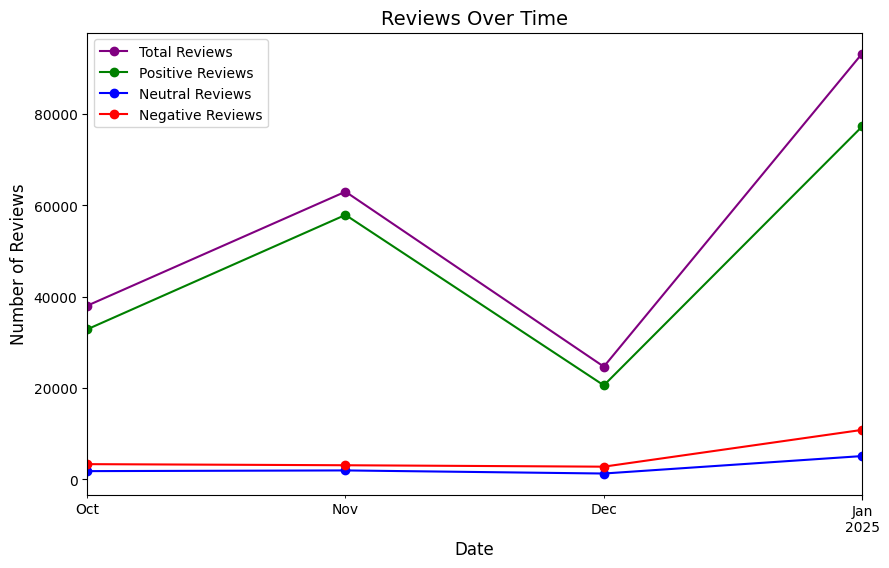

In [24]:
# 8 Reviews over time: number of reviews divided monthly

df_monthly = df.resample("ME", on="inserted_on").size()
df_monthly_positive = df[df["rating"].isin([4, 5])].resample("ME", on="inserted_on").size()
df_monthly_neutral = df[df["rating"] == 3].resample("ME", on="inserted_on").size()
df_monthly_negative = df[df["rating"].isin([1, 2])].resample("ME", on="inserted_on").size()

plt.figure(figsize=(10, 6))
df_monthly.plot(marker="o", linestyle="-", color="purple", label="Total Reviews")
df_monthly_positive.plot(marker="o", linestyle="-", color="green", label="Positive Reviews")
df_monthly_neutral.plot(marker="o", linestyle="-", color="blue", label="Neutral Reviews")
df_monthly_negative.plot(marker="o", linestyle="-", color="red", label="Negative Reviews")

plt.title("Reviews Over Time", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Number of Reviews", fontsize=12)
plt.legend()
plt.show()

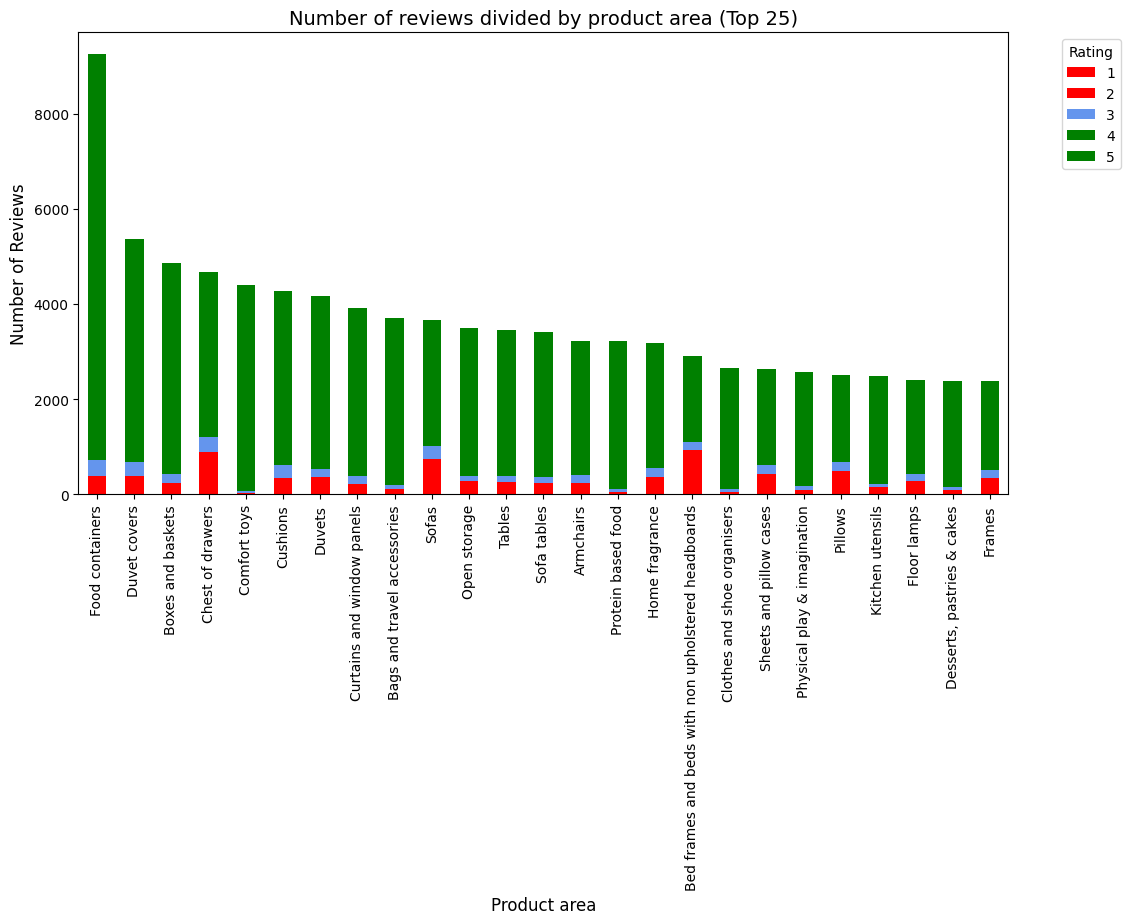

In [25]:
# 9 Product area: Distribution and count

area_counts = df['product_area'].value_counts()

top_25_areas = area_counts.nlargest(25).index

df_top_25 = df[df['product_area'].isin(top_25_areas)]

pivot_table = df_top_25.pivot_table(index='product_area', columns='rating', aggfunc='size', fill_value=0)

pivot_table = pivot_table.reindex(columns=[1, 2, 3, 4, 5], fill_value=0)

pivot_table['total'] = pivot_table.sum(axis=1)

pivot_table = pivot_table.sort_values(by='total', ascending=False)

pivot_table = pivot_table.drop(columns='total')

pivot_table.plot(kind='bar', stacked=True, figsize=(12, 6),
                 color={1: 'red', 2: 'red', 3: 'cornflowerblue', 4: 'green', 5: 'green'})

plt.title("Number of reviews divided by product area (Top 25)", fontsize=14)
plt.xlabel("Product area", fontsize=12)
plt.ylabel("Number of Reviews", fontsize=12)
plt.xticks(rotation=90)
plt.legend(title='Rating', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

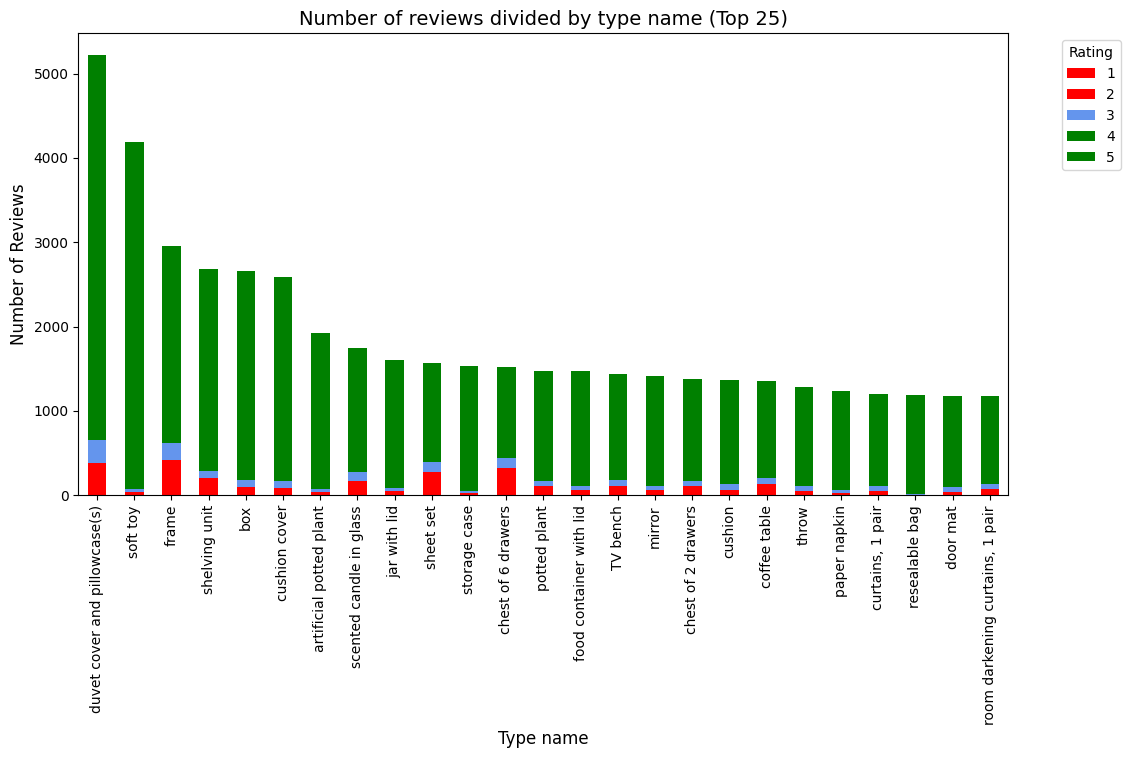

In [26]:
# 10 Type name: Distribution and count

type_counts = df['type_name'].value_counts()

top_25_types = type_counts.nlargest(25).index

df_top_25 = df[df['type_name'].isin(top_25_types)]

pivot_table = df_top_25.pivot_table(index='type_name', columns='rating', aggfunc='size', fill_value=0)

pivot_table = pivot_table.reindex(columns=[1, 2, 3, 4, 5], fill_value=0)

pivot_table['total'] = pivot_table.sum(axis=1)

pivot_table = pivot_table.sort_values(by='total', ascending=False)

pivot_table = pivot_table.drop(columns='total')

pivot_table.plot(kind='bar', stacked=True, figsize=(12, 6),
                 color={1: 'red', 2: 'red', 3: 'cornflowerblue', 4: 'green', 5: 'green'})

plt.title("Number of reviews divided by type name (Top 25)", fontsize=14)
plt.xlabel("Type name", fontsize=12)
plt.ylabel("Number of Reviews", fontsize=12)
plt.xticks(rotation=90)
plt.legend(title='Rating', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [27]:
# 11 Sentiment Analysis: checking if the rating matches the sentiment

from textblob import TextBlob

# Function to translate text to English if necessary
def translate_to_english(text, lang_code):
    try:
        if lang_code != 'en': 
            text = TextBlob(text).translate(to='en')
        return str(text)
    except Exception as e:
        return None

df['translated_text'] = df.apply(lambda row: translate_to_english(row['text'], row['lang_code']), axis=1)

df = df.dropna(subset=['translated_text'])

# Function to calculate sentiment polarity
def calculate_sentiment(text):
    try:
        return TextBlob(text).sentiment.polarity
    except:
        return None

df['sentiment_score'] = df['translated_text'].apply(calculate_sentiment)

# Categorize sentiment based on polarity
def categorize_sentiment(score):
    if score > 0.1:
        return "Positive"
    elif score < -0.1:
        return "Negative"
    else:
        return "Neutral"

# Categorize ratings into sentiment categories
def rating_to_sentiment(rating):
    if rating in [4, 5]:
        return "Positive"
    elif rating == 3:
        return "Neutral"
    else:
        return "Negative"

sentiment_categories = df['sentiment_score'].apply(categorize_sentiment)
rating_categories = df['rating'].apply(rating_to_sentiment)

# Calculate reliability scores
total_reviews = len(df)

positive_matches = ((sentiment_categories == "Positive") & (rating_categories == "Positive")).sum()
neutral_matches = ((sentiment_categories == "Neutral") & (rating_categories == "Neutral")).sum()
negative_matches = ((sentiment_categories == "Negative") & (rating_categories == "Negative")).sum()

positive_total = (rating_categories == "Positive").sum()
neutral_total = (rating_categories == "Neutral").sum()
negative_total = (rating_categories == "Negative").sum()

positive_reliability = positive_matches / positive_total if positive_total > 0 else 0
neutral_reliability = neutral_matches / neutral_total if neutral_total > 0 else 0
negative_reliability = negative_matches / negative_total if negative_total > 0 else 0

overall_reliability = (positive_matches + neutral_matches + negative_matches) / total_reviews

print(f"Positive Reliability: {positive_reliability:.2%}")
print(f"Neutral Reliability: {neutral_reliability:.2%}")
print(f"Negative Reliability: {negative_reliability:.2%}")
print(f"Overall Reliability: {overall_reliability:.2%}")


Positive Reliability: 84.99%
Neutral Reliability: 33.27%
Negative Reliability: 24.66%
Overall Reliability: 77.04%


In [28]:
# Find misclassified reviews
misclassified_reviews = df[sentiment_categories != rating_categories]

# Print some examples of misclassified reviews
print("\nExamples of Misclassified Reviews:")
for index, row in misclassified_reviews.head(3).iterrows():
    print(f"Review Text: {row['text']}")
    print(f"TextBlob Sentiment: {row['sentiment_score']}")
    print(f"Rating: {row['rating']}")
    print(f"Sentiment Category: {sentiment_categories[index]}")
    print(f"Rating Category: {rating_categories[index]}")
    print("-" * 50)



Examples of Misclassified Reviews:
Review Text: Looks nice, a fine printer stand, but if you want to use the drawer for standard hanging file folders it does not support. Disappointed as this was planned to be the working file area near my desk, now it is just a junk drawer.
TextBlob Sentiment: 0.07333333333333332
Rating: 2
Sentiment Category: Neutral
Rating Category: Negative
--------------------------------------------------
Review Text: Some engineers had way too much fun designing this cabinet or IKEA just wants more business for TaskRabbit. This is a cabinet with a drawer, not a mechanical device, it doesn't need to be that complicated. I was lucky that I had over 5 years of experience building lego sets so I was able to build this after 2 hours! On a serious note, this is a beautiful and sturdy cabinet. 3 stars because the cabinet looks beautiful, it's also well built and the drawer mechanism works flawlessly.
TextBlob Sentiment: 0.3825
Rating: 3
Sentiment Category: Positive
Rat